In [4]:
import os
from getpass import getpass
from dotenv import load_dotenv

config = dotenv_values(".env")


# ------------------ Environment Setup ------------------
load_dotenv()  # Load environment variables from .env file

# Retrieve API keys from environment variables
lang_api_key = os.getenv("LANGCHAIN_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")

if lang_api_key:
    print("LangChain Key Imported")
else:
    print("No LangChain Key")

if openai_api_key:
    print("OpenAI Key Imported")
else:
    print("No OpenAI Key")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "coverletter"

openai_model = "gpt-4o-mini"

LangChain Key Imported
OpenAI Key Imported


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain.agents import load_tools, initialize_agent, AgentType


llm = ChatOpenAI(temperature=0.0, model=openai_model)

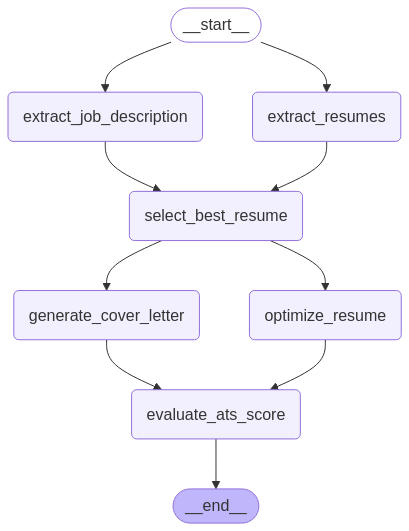

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import TypedDict, List
from langchain.chat_models import ChatOpenAI
# import langgraph.dev as dev
import os
import PyPDF2

# Initialize OpenAI LLM
# llm = ChatOpenAI(model="gpt-4-turbo")

# Define state
class State(TypedDict):
    job_description: str
    resumes: List[dict]
    best_resume: dict
    cover_letter: str
    optimized_resume: dict
    ats_score_before: float
    ats_score_after: float

# ------------------ Helper Function for Resume Extraction ------------------
def extract_text_from_pdf(pdf_path):
    """Extracts text from a given PDF file."""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

# ------------------ Nodes ------------------

def extract_job_description(state: State):
    """Extracts structured data from a job description."""
    msg = llm.invoke(f"Extract key details (Company, Role, Must-Have Skills) from this JD: {state['job_description']}")
    return {"job_description": msg.content}


def extract_resumes(state: State):
    """Extracts structured data from resumes stored in a folder."""
    resume_folder = "pdfs/"  # Folder containing resumes
    resume_files = [os.path.join(resume_folder, file) for file in os.listdir(resume_folder) if file.endswith(".pdf")]
    extracted_resumes = []
    
    for file in resume_files:
        resume_text = extract_text_from_pdf(file)
        msg = llm.invoke(f"Extract Name, Skills, Experience, Education from this resume: {resume_text}")
        extracted_resumes.append(msg.content)
    
    return {"resumes": extracted_resumes}


def select_best_resume(state: State):
    """Compares resumes against JD requirements and selects the best match."""
    msg = llm.invoke(f"Compare these resumes against the JD and return the best match: {state['resumes']}")
    return {"best_resume": msg.content}


def generate_cover_letter(state: State):
    """Generates a personalized cover letter based on the selected resume and JD."""
    msg = llm.invoke(f"Write a personalized cover letter for {state['best_resume']} using the JD {state['job_description']}")
    return {"cover_letter": msg.content}


def optimize_resume(state: State):
    """Improves resume bullet points based on JD skills."""
    msg = llm.invoke(f"Refine resume bullets to better match JD skills: {state['best_resume']}")
    return {"optimized_resume": msg.content}


def evaluate_ats_score(state: State):
    """Computes ATS score before & after resume optimization."""
    # msg_before = llm.invoke(f"Evaluate ATS score for this resume: {state['best_resume']}")
    msg_before = llm.invoke(f"Evaluate ATS score (out of 100) for this resume. Return only a number: {state['best_resume']}")
    # msg_after = llm.invoke(f"Evaluate ATS score for this optimized resume: {state['optimized_resume']}")
    msg_after = llm.invoke(f"Evaluate ATS score (out of 100) for this optimized resume. Return only a number: {state['optimized_resume']}")
    return {"ats_score_before": float(msg_before.content), "ats_score_after": float(msg_after.content)}

# ------------------ Build Workflow ------------------

workflow = StateGraph(State)

# Add nodes
workflow.add_node("extract_job_description", extract_job_description)
workflow.add_node("extract_resumes", extract_resumes)
workflow.add_node("select_best_resume", select_best_resume)
workflow.add_node("generate_cover_letter", generate_cover_letter)
workflow.add_node("optimize_resume", optimize_resume)
workflow.add_node("evaluate_ats_score", evaluate_ats_score)

# Add edges for parallel execution & processing
workflow.add_edge(START, "extract_job_description")
workflow.add_edge(START, "extract_resumes")
workflow.add_edge("extract_job_description", "select_best_resume")
workflow.add_edge("extract_resumes", "select_best_resume")
workflow.add_edge("select_best_resume", "generate_cover_letter")
workflow.add_edge("select_best_resume", "optimize_resume")
workflow.add_edge("optimize_resume", "evaluate_ats_score")
workflow.add_edge("generate_cover_letter", "evaluate_ats_score")
workflow.add_edge("evaluate_ats_score", END)

# Compile workflow
compiled_workflow = workflow.compile()
# Show workflow
display(Image(compiled_workflow.get_graph().draw_mermaid_png()))

In [7]:

# Enable debugging with LangGraph Dev
# dev.enable_tracing(True)

# Run workflow
state = compiled_workflow.invoke({
    "job_description": "Tesla is hiring a Data Scientist with Python, SQL, and ML experience.",
    "resumes": []  # Resume PDFs will be extracted from the folder
})

print("\n🚀 Final Output:\n", state)



🚀 Final Output:
 {'job_description': '**Company:** Tesla  \n**Role:** Data Scientist  \n**Must-Have Skills:** Python, SQL, Machine Learning (ML)', 'resumes': ['**Name:** Pranav Garg\n\n**Skills:**\n- **Software:** Azure, AWS, Snowflake, Coupa, Power BI, Docker, Oracle, Git, SAP Modules (PP, M), GCP, Hadoop, Excel\n- **Languages:** R, Python (NumPy, Pandas, Scikit-learn, Keras, LangChain, LLM), SQL, Java, RDBMS, HTML, C, C++, Shell Script\n- **Concepts:** GenAI, LLM, NLP, Forecasting, Deep Learning, A/B Testing, ERP Transformation, Google BigQuery\n- **Data Science:** Data Exploration, Data Cleaning, Data Analysis, Data Visualization, Data Mining, Predictive Data Models, Text Mining, ETL, Machine Learning, Data Modeling, Regression, Classification\n- **Soft Skills:** Communication Skills, Agile Methodology, People Management, Team Motivation, Adaptability, Business Strategy\n- **Certifications:** Microsoft Azure Fundamentals, Snowflake: Data Warehouse, Data Science & Statistics Foundat

In [8]:
print("\n🚀 Final Output:\n")

print("📌 Job Description:")
print(state["job_description"])
print("\n" + "-" * 80 + "\n")

print("📌 Extracted Resumes:")
for i, resume in enumerate(state["resumes"], start=1):
    print(f"🔹 Resume {i}:")
    print(resume)
    print("\n" + "-" * 80 + "\n")

print("📌 Best Matching Resume:")
print(state["best_resume"])
print("\n" + "-" * 80 + "\n")

print("📌 Generated Cover Letter:")
print(state["cover_letter"])
print("\n" + "-" * 80 + "\n")

print("📌 Optimized Resume:")
print(state["optimized_resume"])
print("\n" + "-" * 80 + "\n")

print(f"📌 ATS Score Before Optimization: {state['ats_score_before']}/100")
print(f"📌 ATS Score After Optimization: {state['ats_score_after']}/100")


🚀 Final Output:

📌 Job Description:
**Company:** Tesla  
**Role:** Data Scientist  
**Must-Have Skills:** Python, SQL, Machine Learning (ML)

--------------------------------------------------------------------------------

📌 Extracted Resumes:
🔹 Resume 1:
**Name:** Pranav Garg

**Skills:**
- **Software:** Azure, AWS, Snowflake, Coupa, Power BI, Docker, Oracle, Git, SAP Modules (PP, M), GCP, Hadoop, Excel
- **Languages:** R, Python (NumPy, Pandas, Scikit-learn, Keras, LangChain, LLM), SQL, Java, RDBMS, HTML, C, C++, Shell Script
- **Concepts:** GenAI, LLM, NLP, Forecasting, Deep Learning, A/B Testing, ERP Transformation, Google BigQuery
- **Data Science:** Data Exploration, Data Cleaning, Data Analysis, Data Visualization, Data Mining, Predictive Data Models, Text Mining, ETL, Machine Learning, Data Modeling, Regression, Classification
- **Soft Skills:** Communication Skills, Agile Methodology, People Management, Team Motivation, Adaptability, Business Strategy
- **Certifications:** M